### Validation of multiprobability model and post-processing steps
5.21.25

Our validation data are for one point in time. This is to assess the accuracy of our multi-probability model and post-processing steps
We match these at the monthly time step

In [3]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import rasterio

#### Import training data

Checking for typos in the Type column:
Santa Maria
	unique types ['hoop' 'mulch' 'other']
	number of rows: 1748
Watsonville
	unique types ['mulch' 'hoop' 'other' 'blackmulch' 'greenhouse']
	number of rows: 2346
Oxnard
	unique types ['hoop' 'mulch' 'blackmulch' 'other']
	number of rows: 1533
CA
	unique types ['other']
	number of rows: 165
Total number of training points: 5792
	unique types ['hoop' 'mulch' 'other' 'blackmulch' 'greenhouse']
Number of rows in each class of Type:
Type
other         2682
mulch         1527
hoop          1407
blackmulch     149
greenhouse      27
Name: count, dtype: int64
unique dates: ['2022-08-26' '2023-05-05' '2022-03-10' '2021-02-06' '2020-09-26'
 '2021-09-27' '2022-09-11' '2023-04-12' '2019-11-17' '2023-07-09'
 '2023-11-09' '2019-10-14' '2023-05-06' '2022-10-01' '2022-11-01'
 '2018-11-19' '2019-04-01' '2019-05-17' '2022-09-21' '2022-06-13'
 '2021-07-13' '2023-10-17' '2020-02-15' '2023-05-11' '2019-08-19'
 '2023-05-07' '2023-08-01' '2021-02-28' '2023-05-

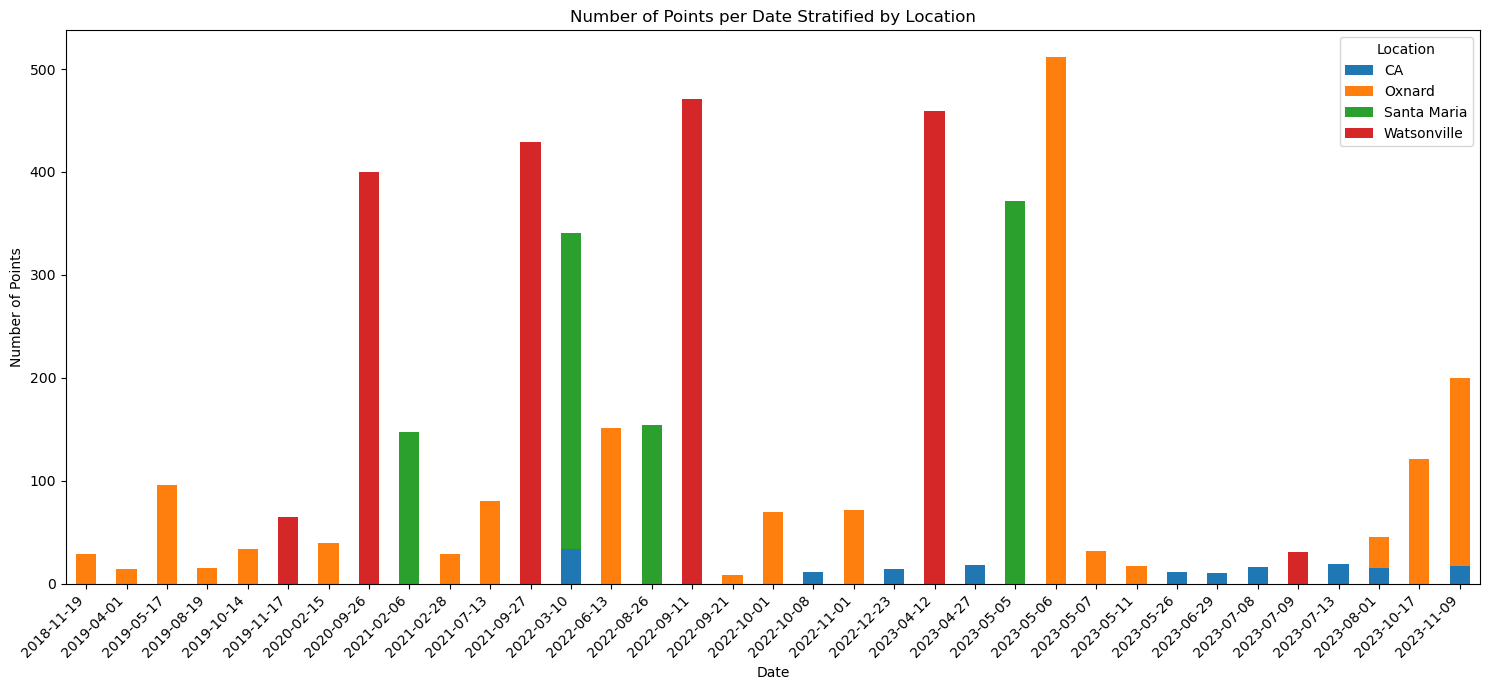

In [4]:
# Training data - local
# Import the csvs with lat/longs as dfs (could all be one csv/df, keeping separate for testing)
train_path = "N:/OCEANS_Program/Plastics/Agricultural_Plastics/Validated Training Data/"
santamaria = pd.read_csv(train_path + 'SantaMaria_val_o.csv')
mendocino = pd.read_csv(train_path + 'MendocinoCounty_val_o.csv')
# watsonville = pd.read_csv(train_path + 'Watsonville_val.csv')
watsonville = pd.read_csv(train_path + 'Watsonville_val_BM.csv')
# replace 'black mulch' with 'blackmulch' to avoid issues with space in label
watsonville['Type'] = watsonville['Type'].replace('black mulch', 'blackmulch')
oxnard_original = pd.read_csv(train_path + 'YYT_RElabeled_points_date_fixed.csv')
# Drop the 'TARGET_FID' column from the 'oxnard' DataFrame - shouldn't need this anymore
# oxnard_original = oxnard_original.drop('TARGET_FID', axis=1)
oxnard_add = pd.read_csv(train_path + 'Oxnard_additional_val.csv')
oxnard = pd.concat([oxnard_original, oxnard_add], axis=0, ignore_index=True)
# importing new other trees dataset
othertrees = pd.read_csv(train_path + 'Brandee_Other_Trees_2025.csv')


# Print out unique 'Type' values for each df to check for typos
print('Checking for typos in the Type column:')
# all_dfs = [santamaria, mendocino, watsonville, oxnard]
all_dfs = [santamaria, watsonville, oxnard, othertrees]
for df in all_dfs:
    print(df['Location'].iloc[0])
    print('\tunique types', df['Type'].unique())
    print('\tnumber of rows:', df.shape[0])

all_data = pd.concat(all_dfs, axis=0, ignore_index=True)
print('Total number of training points:', all_data.shape[0])
print('\tunique types', all_data['Type'].unique())
print('Number of rows in each class of Type:')
print(all_data['Type'].value_counts())
# print('unique dates:', all_data['Date'].unique())

# removing unused dates from the training data to get metadata/stats

all_data_test = all_data
# remove dates before 2018-05-09
all_data_test['Date'] = pd.to_datetime(all_data_test['Date']).dt.strftime('%Y-%m-%d')
all_data_test = all_data_test[all_data_test['Date'] > '2018-05-09']
all_data_test = all_data_test[all_data_test['Type'] != 'greenhouse']
print('unique dates:', all_data_test['Date'].unique())
print('Total number of training points:', all_data_test.shape[0])
print('\tunique types', all_data_test['Type'].unique())
print('Number of rows in each class of Type:')
print(all_data_test['Type'].value_counts())
print(all_data_test['Location'].value_counts())
# display('Watsonville dates: ', all_data_test[all_data_test['Location'] == 'Watsonville']['Date'].unique())
# display('Oxnard dates: ', all_data_test[all_data_test['Location'] == 'Oxnard']['Date'].unique())
# display('Santa Maria dates: ', all_data_test[all_data_test['Location'] == 'Santa Maria']['Date'].unique())

# print a chart showing the number of points per date, stratified by Location
# Group the data by 'Date' and 'Location' and count the number of points
grouped_data = all_data_test.groupby(['Date', 'Location']).size().reset_index(name='Count')
pivot_data = grouped_data.pivot(index='Date', columns='Location', values='Count').fillna(0)
pivot_data.plot(kind='bar', stacked=True, figsize=(15, 7))
plt.title('Number of Points per Date Stratified by Location')
plt.xlabel('Date')
plt.ylabel('Number of Points')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Location')
plt.tight_layout()
plt.show()

#### Import watsonville raster and watsonville training data

In [12]:
# filter all_data_test to only points from 2023-04-12
wats_april23 = all_data_test[all_data_test['Date'] == '2023-04-12']
print('Number of training points in wats/april2023:', wats_april23.shape[0])

df = wats_april23
raster = 'N:/OCEANS_Program/Plastics/Agricultural_Plastics/AgPlastics_Pro/EE_uploads_exports/v1_1/PlasticClass_SantaCruzCo_April2023_v1_1.tif'

# Open the raster file
with rasterio.open(raster) as src:
    # Create a list of coordinates from the dataframe
    coord_list = [(x, y) for x, y in zip(df["Longitude"], df["Latitude"])]
    # Sample the raster at the given coordinates
    df[['class_april23']] = [a for a in src.sample(coord_list)]

df.head()

Number of training points in wats/april2023: 459


E:\Users\annalise.taylor\AppData\Local\Temp\136\ipykernel_96344\2731121053.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['class_april23']] = [a for a in src.sample(coord_list)]


,Location,Type,Date,Latitude,Longitude,Region,class_april23
3526,Watsonville,mulch,2023-04-12,36.915180,-121.833665,NaN,2
3527,Watsonville,mulch,2023-04-12,36.914950,-121.833691,NaN,2
3528,Watsonville,mulch,2023-04-12,36.914661,-121.833874,NaN,2
3529,Watsonville,mulch,2023-04-12,36.915090,-121.833886,NaN,2
3530,Watsonville,mulch,2023-04-12,36.914845,-121.833970,NaN,2


#### Compare actual vs predicted values

E:\Users\annalise.taylor\AppData\Local\Temp\136\ipykernel_96344\3034972378.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['class_april23'] = df['class_april23'].replace({0: 'other', 1: 'hoop', 2: 'mulch'})


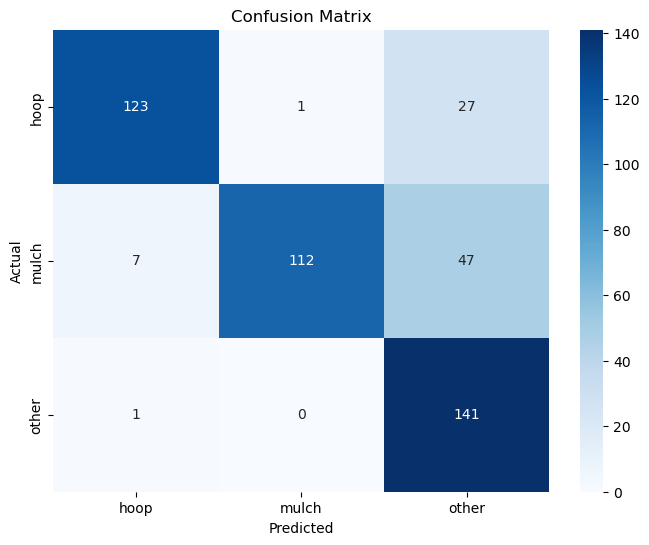

Accuracy: 0.82


In [17]:
df['class_april23'] = df['class_april23'].replace({0: 'other', 1: 'hoop', 2: 'mulch'})
# confusion matrix compare actual (type) to predicted (class_april23)
cm = confusion_matrix(df['Type'], df['class_april23'], labels=['hoop', 'mulch', 'other'])
# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['hoop', 'mulch', 'other'], yticklabels=['hoop', 'mulch', 'other'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
accuracy = np.trace(cm) / np.sum(cm)
print(f'Accuracy: {accuracy:.2f}')